In this notebook a **simple** NDVI time series approach is explored to predict the NDVI in a single region of Senegal.
- Model: SARIMA(X)
- Data: The data was downloaded and processed by Ondrej from ASAP, and is located in the google drive.
    - The dataset contains 10-day information (unlike what we have from GEE and IPAR). The goal is to see the feasability with a ready-to-go dataset that scans many years. 
    - Data: https://drive.google.com/drive/folders/1hRS1mx2YES-nbCCn9OFmciSQhorHeAds?usp=sharing
    - Notebook: https://github.com/OmdenaAI/GPSDD-Food-Security-Senegal/blob/main/notebooks/task_1_climate-risk/ASAP_data_1.ipynb
- Then the model is 'trained' on 2002-2018 + 2018 data (including) up to June, with the aim to predict the NDVI for the rest of the season (July, August, September, ... ) within the current year
- Focus on the simples model: SARIMA 
  - Prediction of NDVI based on solely past NDVI data (SARIMA). 
- The models are saved to be used in yield prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import datetime as dt

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from itertools import product

import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# Metrics from sklearn
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

#from tqdm import tqdm_notebook
#from itertools import product
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
asap_file_path = '../../data/external/SEN_asap_region.csv'

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

In [3]:
asap_file = pd.read_csv(asap_file_path, parse_dates=['date'])
asap_file.head(10)

,Unnamed: 0,region_name,variable_name,sensor_name,class_name,date,value,year,month,day,yearday
0,0,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-01-01,25.302,1989,1,1,1
1,1,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-01-11,26.047,1989,1,11,11
2,2,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-05-01,31.429,1989,5,1,121
3,3,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-05-11,32.047,1989,5,11,131
4,4,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-05-21,32.364,1989,5,21,141
5,5,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-06-01,31.287,1989,6,1,152
6,6,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-06-11,28.216,1989,6,11,162
7,7,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-06-21,27.000,1989,6,21,172
8,8,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-07-01,26.000,1989,7,1,182
9,9,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-07-11,26.000,1989,7,11,192


In [4]:
classes = asap_file["class_name"].unique()
regions = asap_file["region_name"].unique()
variables = asap_file["variable_name"].unique()
print(classes)
print(variables)
print(regions)

['Rangeland during growing cycle' 'Crop during growing cycle' 'Rangeland'
 'Crop']
['Temperature' 'NDVI Cumulated - zscore' 'SPI - 3 months'
 'Water Satisfaction Index (WSI)' 'NDVI - zscore' 'NDVI' 'Rainfall']
['Kolda' 'Fatick' 'Dakar' 'Kedougou' 'Tambacounda' 'Sedhiou' 'Kaffrine'
 'Kaolack' 'Thies' 'Ziguinchor' 'Diourbel' 'Saint louis' 'Louga' 'Matam']


In [5]:
def are_dates_unique(df):
    if(len(df["date"].unique())== df.shape[0]):
        return True
    else:
        return False
    
def date_as_index(df):
    if are_dates_unique(df):
        df = df.set_index('date')
        df.sort_index(inplace=True)
        return df
    else:
        warnings.warn('Dates are not unique, could not set them as indices')
        return df
    
# For now keeping some additional info as class_name, region_name etc although they will be specific
def region_class_value_specific_df(df, cl, region, wanted_columns = ["class_name","region_name", "variable_name", "date", "value"]):
    selected_subset_df = df.loc[(df["class_name"] == cl) &  (df["region_name"] == region), wanted_columns]
    df_ndvi = selected_subset_df.loc[(df["variable_name"] == "NDVI")]
    df_temperature = selected_subset_df.loc[(df["variable_name"] == "Temperature")]
    df_rainfall = selected_subset_df.loc[(df["variable_name"] == "Rainfall")]
    # use dates as indices (if they are unique)
    df_ndvi = date_as_index(df_ndvi)
    df_temperature = date_as_index(df_temperature)
    df_rainfall = date_as_index(df_rainfall)
    
    earliest_date_ndvi = min(df_ndvi.index)
    earliest_date_temperature = min(df_temperature.index)
    earliest_date_rainfall = min(df_rainfall.index)
    earliest_date = max([earliest_date_ndvi, earliest_date_temperature, earliest_date_rainfall])
    print("Earliest date: {}".format(earliest_date))

    last_date_ndvi = max(df_ndvi.index)
    last_date_temperature = max(df_temperature.index)
    last_date_rainfall = max(df_rainfall.index)
    last_date = min([last_date_ndvi, last_date_temperature, last_date_rainfall])
    print("Latest date: {}".format(last_date))
    return df_ndvi, df_temperature, df_rainfall

In [6]:
# Split into training, validation, test 
def split_training_validation_test_by_date(df, min_training='2002-01', max_training='2018-06', min_validation='2018-07', max_validation='2018-12'):
    training_data = df.loc[min_training:max_training]
    validation_data = df.loc[min_validation:max_validation]
    return training_data, validation_data

In [7]:
# Unique regions list
region_list = asap_file['region_name'].unique()
print(region_list)

['Kolda' 'Fatick' 'Dakar' 'Kedougou' 'Tambacounda' 'Sedhiou' 'Kaffrine'
 'Kaolack' 'Thies' 'Ziguinchor' 'Diourbel' 'Saint louis' 'Louga' 'Matam']


In [8]:
# Make a dictionary with region name and ndvi file, we do not need the temperature or rainfall here

region_ndvi_file_dict = {}

for r in region_list:
    print("Current region: {}".format(r))
    crop_ndvi, crop_temperature, crop_rainfall = region_class_value_specific_df(df = asap_file, cl = "Crop", region = r)
    region_ndvi_file_dict[r] = crop_ndvi

Current region: Kolda
Earliest date: 2001-10-01 00:00:00
Latest date: 2020-11-21 00:00:00
Current region: Fatick
Earliest date: 2001-10-01 00:00:00
Latest date: 2020-11-21 00:00:00
Current region: Dakar
Earliest date: 2001-10-01 00:00:00
Latest date: 2020-11-21 00:00:00
Current region: Kedougou
Earliest date: 2001-10-01 00:00:00
Latest date: 2020-11-21 00:00:00
Current region: Tambacounda
Earliest date: 2001-10-01 00:00:00
Latest date: 2020-11-21 00:00:00
Current region: Sedhiou
Earliest date: 2001-10-01 00:00:00
Latest date: 2020-11-21 00:00:00
Current region: Kaffrine
Earliest date: 2001-10-01 00:00:00
Latest date: 2020-11-21 00:00:00
Current region: Kaolack
Earliest date: 2001-10-01 00:00:00
Latest date: 2020-11-21 00:00:00
Current region: Thies
Earliest date: 2001-10-01 00:00:00
Latest date: 2020-11-21 00:00:00
Current region: Ziguinchor
Earliest date: 2001-10-01 00:00:00
Latest date: 2020-11-21 00:00:00
Current region: Diourbel
Earliest date: 2001-10-01 00:00:00
Latest date: 2020-

In [9]:
# Training dictionaryy
region_ndvi_training_dict = {}
region_ndvi_val_dict = {}

for r in region_list:
    
    print("Current region: {}".format(r))
    f = region_ndvi_file_dict[r]
    print(f)
    
    train_crop_ndvi, val_crop_ndvi = split_training_validation_test_by_date(f)
    region_ndvi_training_dict[r] = train_crop_ndvi
    region_ndvi_val_dict[r] = val_crop_ndvi
    print("Training set:")
    print(train_crop_ndvi)
    print("Validation set:")
    print(val_crop_ndvi)
    print("Next!")

Current region: Kolda
           class_name region_name variable_name  value
date                                                  
2001-10-01       Crop       Kolda          NDVI  0.711
2001-10-11       Crop       Kolda          NDVI  0.660
2001-10-21       Crop       Kolda          NDVI  0.595
2001-11-01       Crop       Kolda          NDVI  0.536
2001-11-11       Crop       Kolda          NDVI  0.484
...               ...         ...           ...    ...
2020-10-11       Crop       Kolda          NDVI  0.729
2020-10-21       Crop       Kolda          NDVI  0.680
2020-11-01       Crop       Kolda          NDVI  0.630
2020-11-11       Crop       Kolda          NDVI  0.579
2020-11-21       Crop       Kolda          NDVI  0.529

[690 rows x 4 columns]
Training set:
           class_name region_name variable_name  value
date                                                  
2002-01-01       Crop       Kolda          NDVI  0.328
2002-01-11       Crop       Kolda          NDVI  0.309
2002-

           class_name region_name variable_name  value
date                                                  
2002-01-01       Crop    Kedougou          NDVI  0.354
2002-01-11       Crop    Kedougou          NDVI  0.334
2002-01-21       Crop    Kedougou          NDVI  0.315
2002-02-01       Crop    Kedougou          NDVI  0.302
2002-02-11       Crop    Kedougou          NDVI  0.292
...               ...         ...           ...    ...
2018-05-11       Crop    Kedougou          NDVI  0.309
2018-05-21       Crop    Kedougou          NDVI  0.333
2018-06-01       Crop    Kedougou          NDVI  0.373
2018-06-11       Crop    Kedougou          NDVI  0.430
2018-06-21       Crop    Kedougou          NDVI  0.501

[594 rows x 4 columns]
Validation set:
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop    Kedougou          NDVI  0.573
2018-07-11       Crop    Kedougou          NDVI  0.635
2018-07-21       Crop    

[690 rows x 4 columns]
Training set:
           class_name region_name variable_name  value
date                                                  
2002-01-01       Crop     Kaolack          NDVI  0.271
2002-01-11       Crop     Kaolack          NDVI  0.253
2002-01-21       Crop     Kaolack          NDVI  0.236
2002-02-01       Crop     Kaolack          NDVI  0.225
2002-02-11       Crop     Kaolack          NDVI  0.219
...               ...         ...           ...    ...
2018-05-11       Crop     Kaolack          NDVI  0.197
2018-05-21       Crop     Kaolack          NDVI  0.193
2018-06-01       Crop     Kaolack          NDVI  0.195
2018-06-11       Crop     Kaolack          NDVI  0.202
2018-06-21       Crop     Kaolack          NDVI  0.232

[594 rows x 4 columns]
Validation set:
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop     Kaolack          NDVI  0.273
2018-07-11       Crop     Kaolack          

[594 rows x 4 columns]
Validation set:
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop    Diourbel          NDVI  0.222
2018-07-11       Crop    Diourbel          NDVI  0.244
2018-07-21       Crop    Diourbel          NDVI  0.285
2018-08-01       Crop    Diourbel          NDVI  0.324
2018-08-11       Crop    Diourbel          NDVI  0.382
2018-08-21       Crop    Diourbel          NDVI  0.441
2018-09-01       Crop    Diourbel          NDVI  0.492
2018-09-11       Crop    Diourbel          NDVI  0.532
2018-09-21       Crop    Diourbel          NDVI  0.556
2018-10-01       Crop    Diourbel          NDVI  0.553
2018-10-11       Crop    Diourbel          NDVI  0.521
2018-10-21       Crop    Diourbel          NDVI  0.462
2018-11-01       Crop    Diourbel          NDVI  0.405
2018-11-11       Crop    Diourbel          NDVI  0.356
2018-11-21       Crop    Diourbel          NDVI  0.319
2018-12-01       Crop    D

In [10]:
# For auto arima 
import pmdarima as pm

# For serialization:
import joblib
import pickle

In [11]:
def train_sarima_model(training_df, region_name):
    print("SARIMA for: {}".format(region_name))
    smodel = pm.auto_arima(training_df.value, test='adf',
                           seasonal=True, m=36,
                           start_p=0, start_q=0,
                           max_p=5, max_q=5,
                           start_P=0, start_Q=0,
                           max_P=3, max_Q=3,
                           d=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True, information_criterion='aic')
    
    smodel.summary()
    with open('timeseries_models/sarima_forecast_model_'+region_name+'.pkl', 'wb') as pkl:
        pickle.dump(smodel, pkl, -1)    

In [12]:
for i in range(2):
    r = region_list[i]
    print("Training the model for: {}".format(r))
    training_df = region_ndvi_training_dict[r]
    train_sarima_model(training_df, r)


Training the model for: Kolda
SARIMA for: Kolda
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[36] intercept   : AIC=-422.542, Time=0.47 sec
 ARIMA(1,0,0)(1,0,0)[36] intercept   : AIC=inf, Time=5.96 sec
 ARIMA(0,0,1)(0,0,1)[36] intercept   : AIC=inf, Time=5.21 sec
 ARIMA(0,0,0)(0,0,0)[36]             : AIC=822.982, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[36] intercept   : AIC=inf, Time=6.12 sec
 ARIMA(0,0,0)(0,0,1)[36] intercept   : AIC=inf, Time=5.21 sec
 ARIMA(0,0,0)(1,0,1)[36] intercept   : AIC=inf, Time=23.53 sec
 ARIMA(1,0,0)(0,0,0)[36] intercept   : AIC=-2394.558, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[36] intercept   : AIC=inf, Time=16.20 sec
 ARIMA(1,0,0)(1,0,1)[36] intercept   : AIC=-4064.258, Time=16.99 sec
 ARIMA(1,0,0)(2,0,1)[36] intercept   : AIC=-4072.147, Time=56.82 sec
 ARIMA(1,0,0)(2,0,0)[36] intercept   : AIC=inf, Time=32.33 sec
 ARIMA(1,0,0)(3,0,1)[36] intercept   : AIC=inf, Time=109.99 sec
 ARIMA(1,0,0)(2,0,2)[36] intercept   : AIC=-4101.179, Time=58.99 sec


In [13]:
for i in range(2,len(region_list)):
    r = region_list[i]
    print("Training the model for: {}".format(r))
    training_df = region_ndvi_training_dict[r]
    train_sarima_model(training_df, r)

Training the model for: Dakar
SARIMA for: Dakar
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[36] intercept   : AIC=-793.481, Time=0.23 sec
 ARIMA(1,0,0)(1,0,0)[36] intercept   : AIC=inf, Time=12.83 sec
 ARIMA(0,0,1)(0,0,1)[36] intercept   : AIC=inf, Time=7.84 sec
 ARIMA(0,0,0)(0,0,0)[36]             : AIC=503.376, Time=0.06 sec
 ARIMA(0,0,0)(1,0,0)[36] intercept   : AIC=inf, Time=3.33 sec
 ARIMA(0,0,0)(0,0,1)[36] intercept   : AIC=inf, Time=5.82 sec
 ARIMA(0,0,0)(1,0,1)[36] intercept   : AIC=-2046.389, Time=7.57 sec
 ARIMA(0,0,0)(2,0,1)[36] intercept   : AIC=inf, Time=59.23 sec
 ARIMA(0,0,0)(1,0,2)[36] intercept   : AIC=-2058.409, Time=30.01 sec
 ARIMA(0,0,0)(0,0,2)[36] intercept   : AIC=inf, Time=10.20 sec
 ARIMA(0,0,0)(2,0,2)[36] intercept   : AIC=inf, Time=25.04 sec
 ARIMA(0,0,0)(1,0,3)[36] intercept   : AIC=-2058.704, Time=123.82 sec
 ARIMA(0,0,0)(0,0,3)[36] intercept   : AIC=inf, Time=203.32 sec
 ARIMA(0,0,0)(2,0,3)[36] intercept   : AIC=inf, Time=359.88 sec
 AR

 ARIMA(1,0,2)(1,0,1)[36] intercept   : AIC=inf, Time=11.17 sec
 ARIMA(0,0,2)(1,0,1)[36] intercept   : AIC=-3747.940, Time=13.35 sec
 ARIMA(2,0,0)(1,0,1)[36] intercept   : AIC=inf, Time=10.74 sec
 ARIMA(2,0,2)(1,0,1)[36] intercept   : AIC=-4890.762, Time=21.50 sec
 ARIMA(2,0,2)(0,0,1)[36] intercept   : AIC=-4825.933, Time=10.19 sec
 ARIMA(2,0,2)(1,0,0)[36] intercept   : AIC=-4699.502, Time=17.12 sec
 ARIMA(2,0,2)(2,0,1)[36] intercept   : AIC=-4873.893, Time=69.65 sec
 ARIMA(2,0,2)(1,0,2)[36] intercept   : AIC=-4964.935, Time=67.88 sec
 ARIMA(2,0,2)(0,0,2)[36] intercept   : AIC=-4886.853, Time=37.01 sec
 ARIMA(2,0,2)(2,0,2)[36] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,0,2)(1,0,3)[36] intercept   : AIC=inf, Time=129.18 sec
 ARIMA(2,0,2)(0,0,3)[36] intercept   : AIC=-4917.445, Time=109.85 sec
 ARIMA(2,0,2)(2,0,3)[36] intercept   : AIC=inf, Time=146.14 sec
 ARIMA(1,0,2)(1,0,2)[36] intercept   : AIC=inf, Time=37.25 sec
 ARIMA(2,0,1)(1,0,2)[36] intercept   : AIC=inf, Time=76.22 sec
 ARIMA

 ARIMA(0,0,4)(1,0,0)[36] intercept   : AIC=-4352.610, Time=9.07 sec
 ARIMA(0,0,4)(2,0,1)[36] intercept   : AIC=inf, Time=51.42 sec
 ARIMA(0,0,4)(1,0,2)[36] intercept   : AIC=inf, Time=62.35 sec
 ARIMA(0,0,4)(0,0,0)[36] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0,4)(0,0,2)[36] intercept   : AIC=inf, Time=44.89 sec
 ARIMA(0,0,4)(2,0,0)[36] intercept   : AIC=-4392.080, Time=44.78 sec
 ARIMA(0,0,4)(2,0,2)[36] intercept   : AIC=-4519.857, Time=80.56 sec
 ARIMA(1,0,4)(1,0,1)[36] intercept   : AIC=inf, Time=20.68 sec
 ARIMA(0,0,5)(1,0,1)[36] intercept   : AIC=inf, Time=18.15 sec
 ARIMA(1,0,5)(1,0,1)[36] intercept   : AIC=inf, Time=15.77 sec
 ARIMA(0,0,4)(1,0,1)[36]             : AIC=-4459.810, Time=9.01 sec

Best model:  ARIMA(0,0,4)(1,0,1)[36] intercept
Total fit time: 1227.844 seconds
Training the model for: Kaffrine
SARIMA for: Kaffrine
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[36] intercept   : AIC=-609.972, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[36] intercept   : AI

 ARIMA(1,0,0)(2,0,0)[36] intercept   : AIC=inf, Time=17.38 sec
 ARIMA(1,0,0)(2,0,2)[36] intercept   : AIC=inf, Time=40.66 sec
 ARIMA(2,0,0)(1,0,1)[36] intercept   : AIC=inf, Time=11.91 sec
 ARIMA(1,0,1)(1,0,1)[36] intercept   : AIC=-4343.644, Time=10.70 sec
 ARIMA(1,0,1)(0,0,1)[36] intercept   : AIC=inf, Time=9.17 sec
 ARIMA(1,0,1)(1,0,0)[36] intercept   : AIC=-4182.478, Time=7.55 sec
 ARIMA(1,0,1)(2,0,1)[36] intercept   : AIC=inf, Time=37.82 sec
 ARIMA(1,0,1)(1,0,2)[36] intercept   : AIC=-4336.073, Time=55.44 sec
 ARIMA(1,0,1)(0,0,0)[36] intercept   : AIC=-3087.023, Time=0.53 sec
 ARIMA(1,0,1)(0,0,2)[36] intercept   : AIC=inf, Time=39.58 sec
 ARIMA(1,0,1)(2,0,0)[36] intercept   : AIC=-4197.795, Time=44.84 sec
 ARIMA(1,0,1)(2,0,2)[36] intercept   : AIC=inf, Time=67.39 sec
 ARIMA(0,0,1)(1,0,1)[36] intercept   : AIC=inf, Time=9.00 sec
 ARIMA(2,0,1)(1,0,1)[36] intercept   : AIC=inf, Time=12.03 sec
 ARIMA(1,0,2)(1,0,1)[36] intercept   : AIC=-4738.932, Time=10.24 sec
 ARIMA(1,0,2)(0,0,1)[36

 ARIMA(1,0,0)(0,0,2)[36] intercept   : AIC=inf, Time=17.02 sec
 ARIMA(3,0,0)(0,0,2)[36] intercept   : AIC=-4951.105, Time=29.69 sec
 ARIMA(3,0,0)(0,0,1)[36] intercept   : AIC=-4930.980, Time=6.69 sec
 ARIMA(3,0,0)(1,0,2)[36] intercept   : AIC=inf, Time=37.94 sec
 ARIMA(3,0,0)(0,0,3)[36] intercept   : AIC=inf, Time=86.30 sec
 ARIMA(3,0,0)(1,0,1)[36] intercept   : AIC=inf, Time=4.85 sec
 ARIMA(3,0,0)(1,0,3)[36] intercept   : AIC=inf, Time=156.57 sec
 ARIMA(4,0,0)(0,0,2)[36] intercept   : AIC=-5065.500, Time=39.18 sec
 ARIMA(4,0,0)(0,0,1)[36] intercept   : AIC=-5027.254, Time=8.57 sec
 ARIMA(4,0,0)(1,0,2)[36] intercept   : AIC=-5154.357, Time=38.62 sec
 ARIMA(4,0,0)(1,0,1)[36] intercept   : AIC=inf, Time=12.74 sec
 ARIMA(4,0,0)(2,0,2)[36] intercept   : AIC=inf, Time=46.85 sec
 ARIMA(4,0,0)(1,0,3)[36] intercept   : AIC=inf, Time=163.24 sec
 ARIMA(4,0,0)(0,0,3)[36] intercept   : AIC=-5110.173, Time=152.66 sec
 ARIMA(4,0,0)(2,0,1)[36] intercept   : AIC=inf, Time=51.51 sec
 ARIMA(4,0,0)(2,0,3

 ARIMA(1,0,0)(1,0,0)[36] intercept   : AIC=inf, Time=4.68 sec
 ARIMA(0,0,1)(0,0,1)[36] intercept   : AIC=inf, Time=4.31 sec
 ARIMA(0,0,0)(0,0,0)[36]             : AIC=171.252, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[36] intercept   : AIC=inf, Time=2.57 sec
 ARIMA(0,0,0)(0,0,1)[36] intercept   : AIC=inf, Time=3.98 sec
 ARIMA(0,0,0)(1,0,1)[36] intercept   : AIC=inf, Time=8.55 sec
 ARIMA(1,0,0)(0,0,0)[36] intercept   : AIC=-2701.615, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[36] intercept   : AIC=inf, Time=3.86 sec
 ARIMA(1,0,0)(1,0,1)[36] intercept   : AIC=-3798.011, Time=7.70 sec
 ARIMA(1,0,0)(2,0,1)[36] intercept   : AIC=-3881.499, Time=33.02 sec
 ARIMA(1,0,0)(2,0,0)[36] intercept   : AIC=inf, Time=23.36 sec
 ARIMA(1,0,0)(3,0,1)[36] intercept   : AIC=-3882.208, Time=78.87 sec
 ARIMA(1,0,0)(3,0,0)[36] intercept   : AIC=inf, Time=75.83 sec
 ARIMA(1,0,0)(3,0,2)[36] intercept   : AIC=inf, Time=108.29 sec
 ARIMA(1,0,0)(2,0,2)[36] intercept   : AIC=inf, Time=24.15 sec
 ARIMA(0,0,0)(3,0,1)[36] intercept 

 ARIMA(5,0,2)(1,0,1)[36] intercept   : AIC=-4534.769, Time=22.06 sec
 ARIMA(5,0,4)(1,0,1)[36] intercept   : AIC=-5157.208, Time=32.17 sec
 ARIMA(4,0,3)(1,0,1)[36]             : AIC=inf, Time=13.73 sec

Best model:  ARIMA(4,0,3)(1,0,1)[36] intercept
Total fit time: 3109.680 seconds


In [16]:
# Functions to check the performance of the models
def get_predictions_sarima(model, validation_data):
    forecasted = model.predict(n_periods=(validation_data.shape[0]))
    forecasted_series = pd.Series(forecasted, index=validation_data.index)
    return forecasted_series


In [24]:
def absolute_percentage_error_peak(y_true, y_pred):
    return np.abs(max(y_true) - max(y_pred))/max(y_true) * 100    

def plot_training_validation_forecast(train_crop_ndvi, model_predicted_series, val_crop_ndvi_value, which_model='Year, NDVI only'):
 
    mape = mean_absolute_percentage_error(val_crop_ndvi_value, model_predicted_series)
    mae =  mean_absolute_error(val_crop_ndvi_value, model_predicted_series)
    pvabe = absolute_percentage_error_peak(val_crop_ndvi_value, model_predicted_series)  
    
    fig = plt.figure(figsize=(24,12))
    fig.suptitle("SARIMA(X) - Forecast for model: {0}".format(which_model), fontsize=25)
    plt.subplot(1, 2, 1)
    plt.plot(train_crop_ndvi.value, label = 'Training data')
    plt.plot(model_predicted_series, color='darkgreen', label = 'Forecast')
    plt.plot(val_crop_ndvi_value, color = 'black', label = 'Validation data')
    plt.legend(loc='best')
    plt.grid('True')
    plt.title("Training and forecast period")
    plt.subplot(1, 2, 2)
    plt.plot(model_predicted_series, color='darkgreen', label = 'Forecast')
    plt.plot(val_crop_ndvi_value, color = 'black', label = 'Validation data')
    plt.legend(loc='best')
    plt.grid('True')
    plt.title("Forecast period. Mean abs percent error: {mape:.2f}, Mean abs error: {mae:.3f}:, Peak val abs per error: {pvabe:.2f}".format(mape=mape, mae=mae, pvabe=pvabe), fontsize=14)
    
    plt.show()

Kolda
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop       Kolda          NDVI  0.432
2018-07-11       Crop       Kolda          NDVI  0.491
2018-07-21       Crop       Kolda          NDVI  0.557
2018-08-01       Crop       Kolda          NDVI  0.613
2018-08-11       Crop       Kolda          NDVI  0.663
2018-08-21       Crop       Kolda          NDVI  0.704
2018-09-01       Crop       Kolda          NDVI  0.726
2018-09-11       Crop       Kolda          NDVI  0.735
2018-09-21       Crop       Kolda          NDVI  0.736
2018-10-01       Crop       Kolda          NDVI  0.729
2018-10-11       Crop       Kolda          NDVI  0.710
2018-10-21       Crop       Kolda          NDVI  0.670
2018-11-01       Crop       Kolda          NDVI  0.620
2018-11-11       Crop       Kolda          NDVI  0.565
2018-11-21       Crop       Kolda          NDVI  0.512
2018-12-01       Crop       Kolda          NDVI  0.468
2018

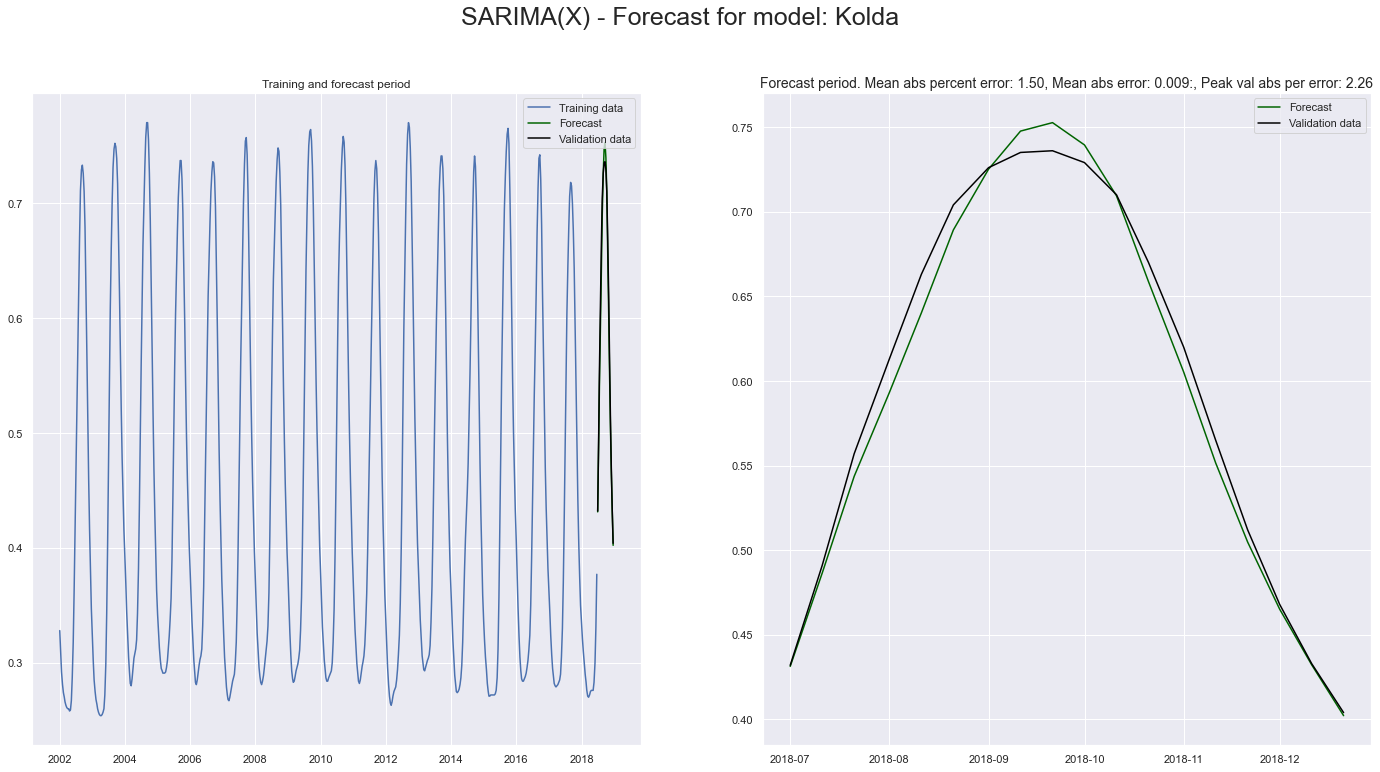

Fatick
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop      Fatick          NDVI  0.260
2018-07-11       Crop      Fatick          NDVI  0.293
2018-07-21       Crop      Fatick          NDVI  0.347
2018-08-01       Crop      Fatick          NDVI  0.397
2018-08-11       Crop      Fatick          NDVI  0.455
2018-08-21       Crop      Fatick          NDVI  0.513
2018-09-01       Crop      Fatick          NDVI  0.553
2018-09-11       Crop      Fatick          NDVI  0.574
2018-09-21       Crop      Fatick          NDVI  0.577
2018-10-01       Crop      Fatick          NDVI  0.558
2018-10-11       Crop      Fatick          NDVI  0.516
2018-10-21       Crop      Fatick          NDVI  0.453
2018-11-01       Crop      Fatick          NDVI  0.397
2018-11-11       Crop      Fatick          NDVI  0.350
2018-11-21       Crop      Fatick          NDVI  0.316
2018-12-01       Crop      Fatick          NDVI  0.294
201

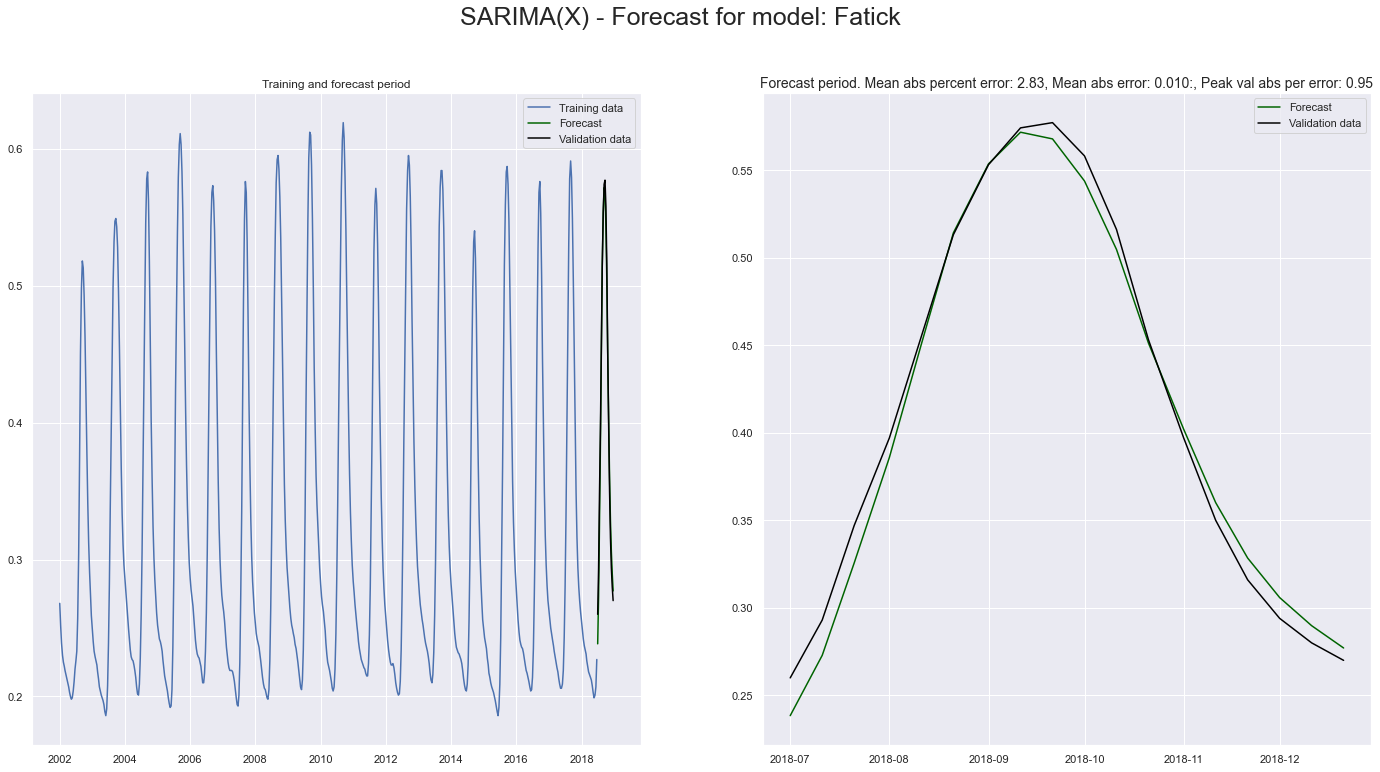

Dakar
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop       Dakar          NDVI  0.253
2018-07-11       Crop       Dakar          NDVI  0.272
2018-07-21       Crop       Dakar          NDVI  0.294
2018-08-01       Crop       Dakar          NDVI  0.314
2018-08-11       Crop       Dakar          NDVI  0.361
2018-08-21       Crop       Dakar          NDVI  0.408
2018-09-01       Crop       Dakar          NDVI  0.454
2018-09-11       Crop       Dakar          NDVI  0.492
2018-09-21       Crop       Dakar          NDVI  0.511
2018-10-01       Crop       Dakar          NDVI  0.499
2018-10-11       Crop       Dakar          NDVI  0.457
2018-10-21       Crop       Dakar          NDVI  0.402
2018-11-01       Crop       Dakar          NDVI  0.360
2018-11-11       Crop       Dakar          NDVI  0.330
2018-11-21       Crop       Dakar          NDVI  0.309
2018-12-01       Crop       Dakar          NDVI  0.296
2018

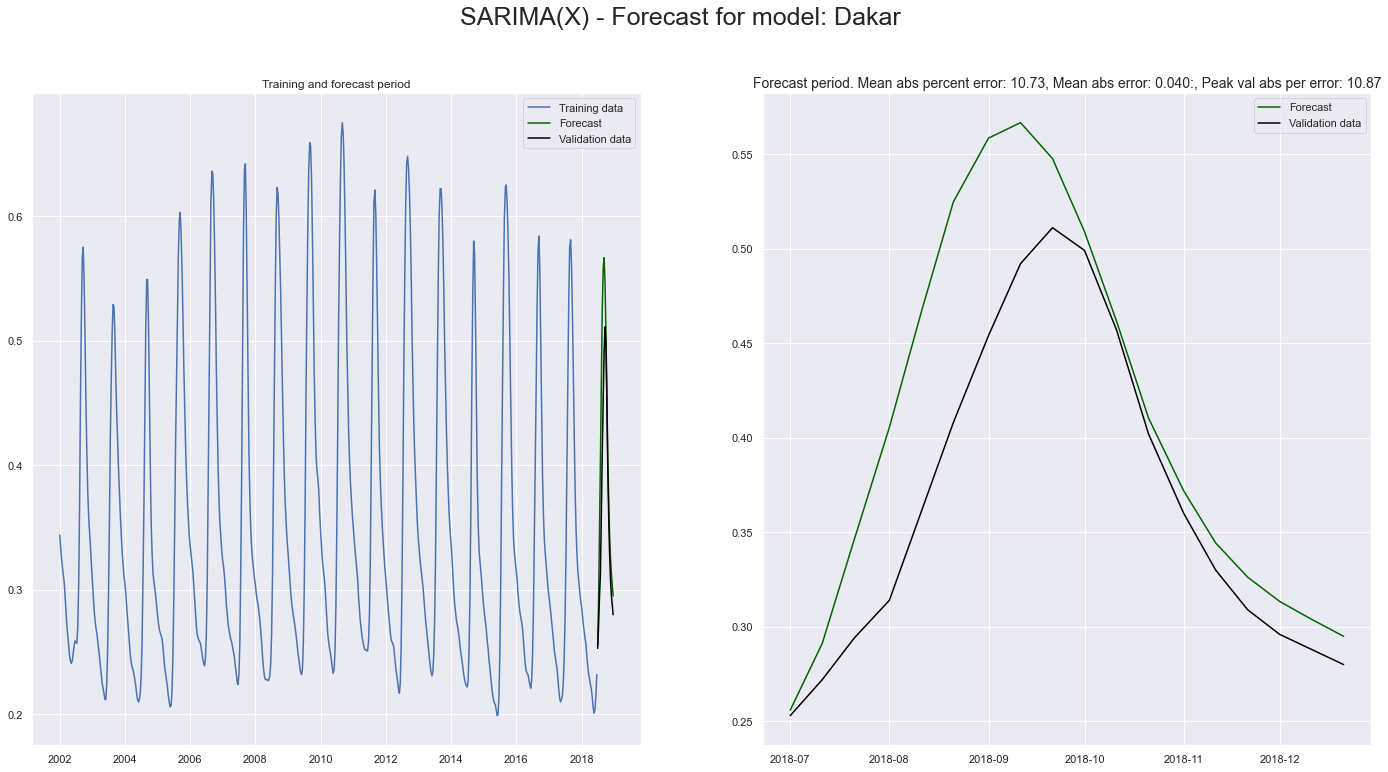

Kedougou
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop    Kedougou          NDVI  0.573
2018-07-11       Crop    Kedougou          NDVI  0.635
2018-07-21       Crop    Kedougou          NDVI  0.691
2018-08-01       Crop    Kedougou          NDVI  0.730
2018-08-11       Crop    Kedougou          NDVI  0.760
2018-08-21       Crop    Kedougou          NDVI  0.783
2018-09-01       Crop    Kedougou          NDVI  0.790
2018-09-11       Crop    Kedougou          NDVI  0.786
2018-09-21       Crop    Kedougou          NDVI  0.773
2018-10-01       Crop    Kedougou          NDVI  0.750
2018-10-11       Crop    Kedougou          NDVI  0.717
2018-10-21       Crop    Kedougou          NDVI  0.671
2018-11-01       Crop    Kedougou          NDVI  0.624
2018-11-11       Crop    Kedougou          NDVI  0.576
2018-11-21       Crop    Kedougou          NDVI  0.529
2018-12-01       Crop    Kedougou          NDVI  0.486
2

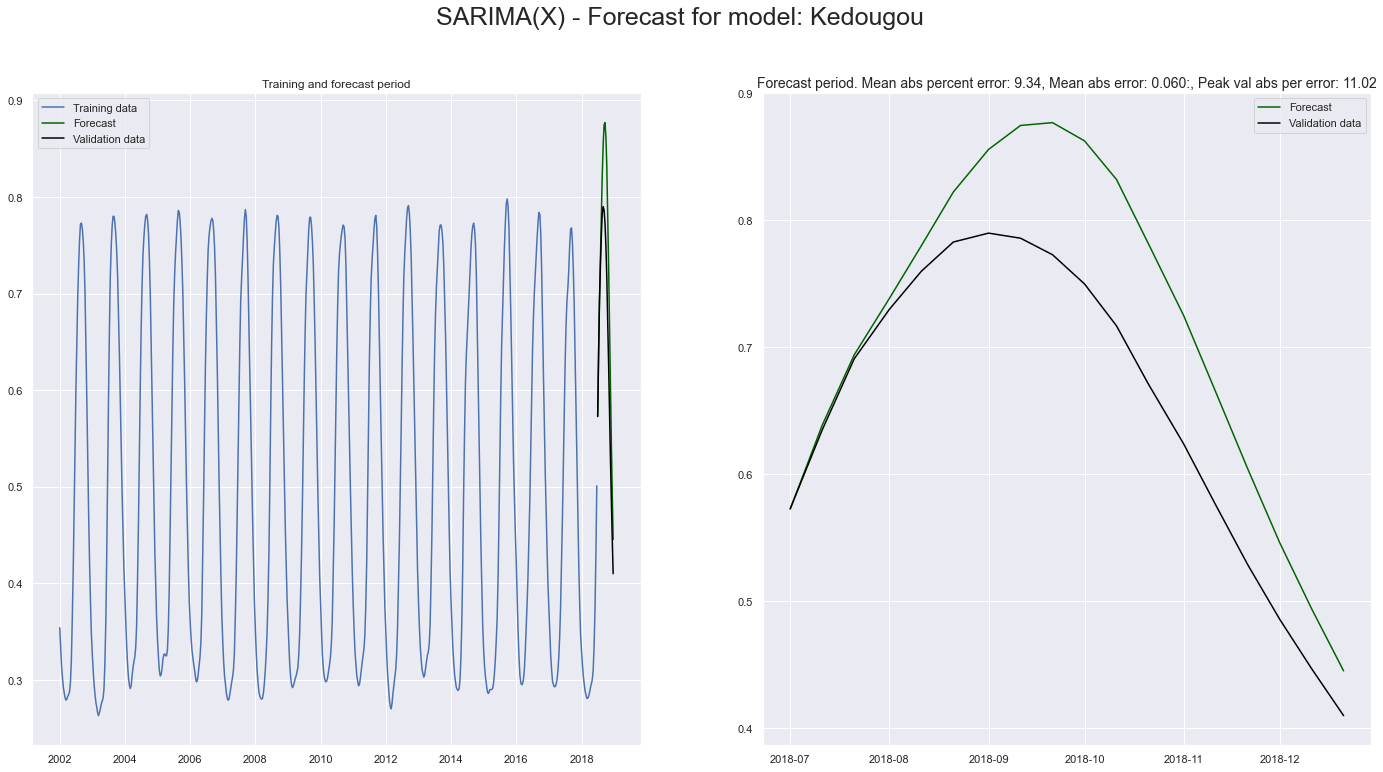

Tambacounda
           class_name  region_name variable_name  value
date                                                   
2018-07-01       Crop  Tambacounda          NDVI  0.301
2018-07-11       Crop  Tambacounda          NDVI  0.347
2018-07-21       Crop  Tambacounda          NDVI  0.412
2018-08-01       Crop  Tambacounda          NDVI  0.476
2018-08-11       Crop  Tambacounda          NDVI  0.547
2018-08-21       Crop  Tambacounda          NDVI  0.616
2018-09-01       Crop  Tambacounda          NDVI  0.664
2018-09-11       Crop  Tambacounda          NDVI  0.691
2018-09-21       Crop  Tambacounda          NDVI  0.691
2018-10-01       Crop  Tambacounda          NDVI  0.661
2018-10-11       Crop  Tambacounda          NDVI  0.607
2018-10-21       Crop  Tambacounda          NDVI  0.532
2018-11-01       Crop  Tambacounda          NDVI  0.465
2018-11-11       Crop  Tambacounda          NDVI  0.407
2018-11-21       Crop  Tambacounda          NDVI  0.364
2018-12-01       Crop  Tambacounda  

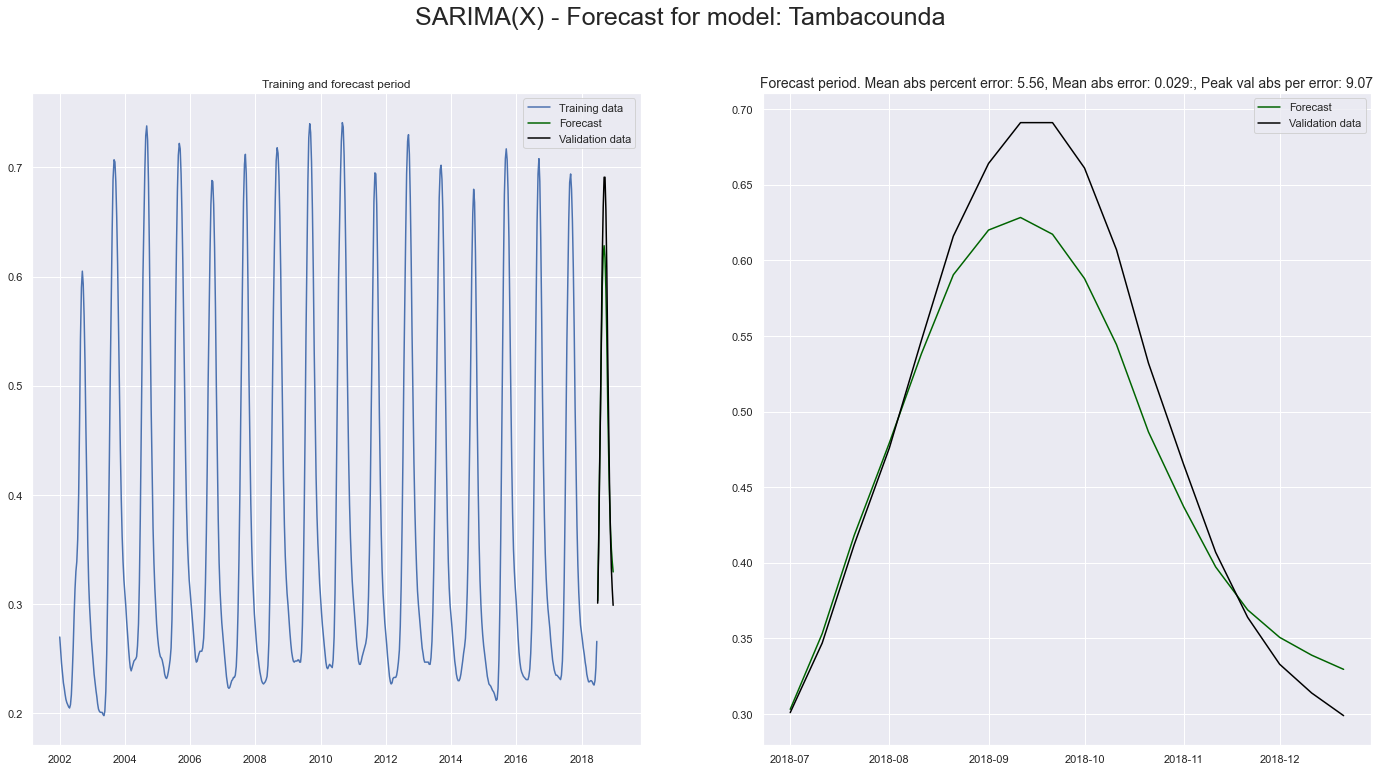

Sedhiou
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop     Sedhiou          NDVI  0.491
2018-07-11       Crop     Sedhiou          NDVI  0.548
2018-07-21       Crop     Sedhiou          NDVI  0.608
2018-08-01       Crop     Sedhiou          NDVI  0.658
2018-08-11       Crop     Sedhiou          NDVI  0.700
2018-08-21       Crop     Sedhiou          NDVI  0.730
2018-09-01       Crop     Sedhiou          NDVI  0.742
2018-09-11       Crop     Sedhiou          NDVI  0.744
2018-09-21       Crop     Sedhiou          NDVI  0.743
2018-10-01       Crop     Sedhiou          NDVI  0.741
2018-10-11       Crop     Sedhiou          NDVI  0.733
2018-10-21       Crop     Sedhiou          NDVI  0.713
2018-11-01       Crop     Sedhiou          NDVI  0.683
2018-11-11       Crop     Sedhiou          NDVI  0.644
2018-11-21       Crop     Sedhiou          NDVI  0.599
2018-12-01       Crop     Sedhiou          NDVI  0.556
20

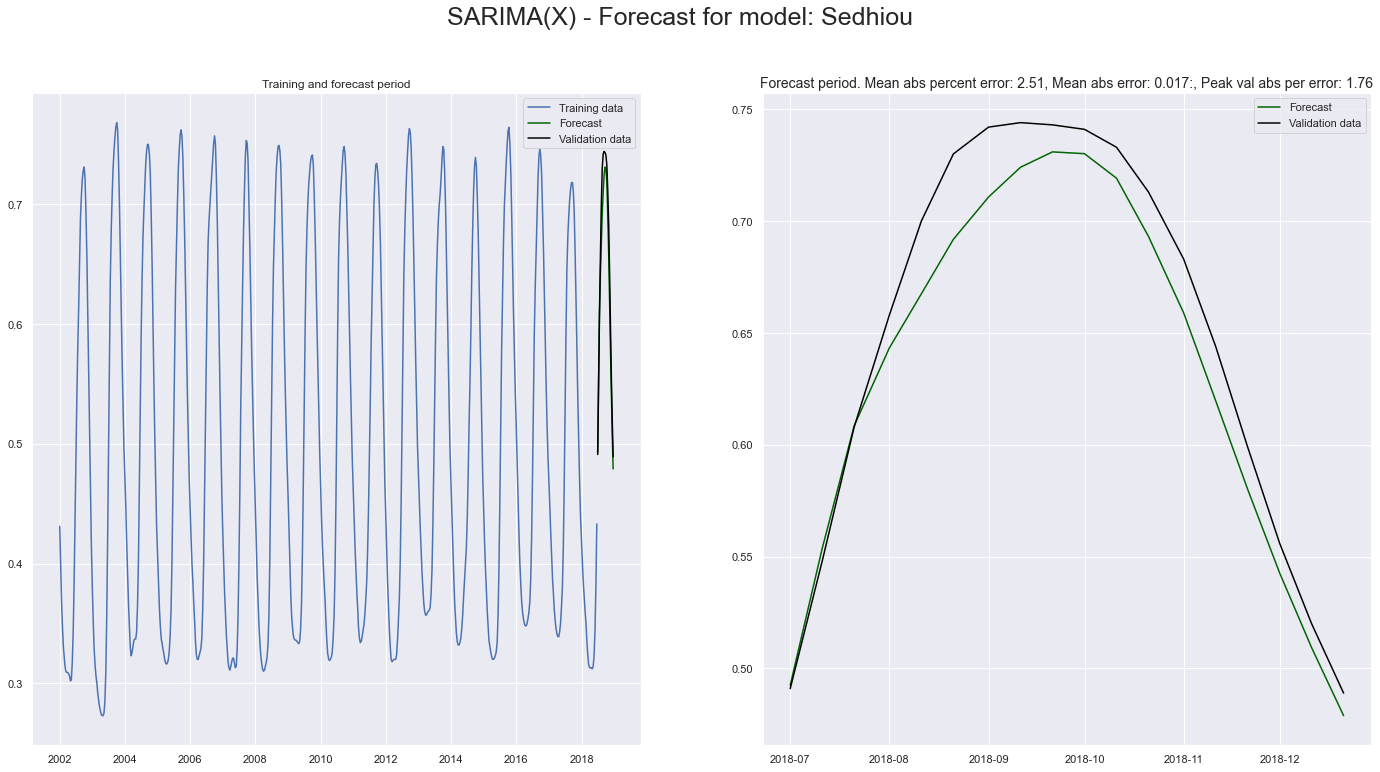

Kaffrine
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop    Kaffrine          NDVI  0.221
2018-07-11       Crop    Kaffrine          NDVI  0.252
2018-07-21       Crop    Kaffrine          NDVI  0.309
2018-08-01       Crop    Kaffrine          NDVI  0.366
2018-08-11       Crop    Kaffrine          NDVI  0.440
2018-08-21       Crop    Kaffrine          NDVI  0.516
2018-09-01       Crop    Kaffrine          NDVI  0.575
2018-09-11       Crop    Kaffrine          NDVI  0.614
2018-09-21       Crop    Kaffrine          NDVI  0.624
2018-10-01       Crop    Kaffrine          NDVI  0.601
2018-10-11       Crop    Kaffrine          NDVI  0.548
2018-10-21       Crop    Kaffrine          NDVI  0.474
2018-11-01       Crop    Kaffrine          NDVI  0.408
2018-11-11       Crop    Kaffrine          NDVI  0.353
2018-11-21       Crop    Kaffrine          NDVI  0.314
2018-12-01       Crop    Kaffrine          NDVI  0.290
2

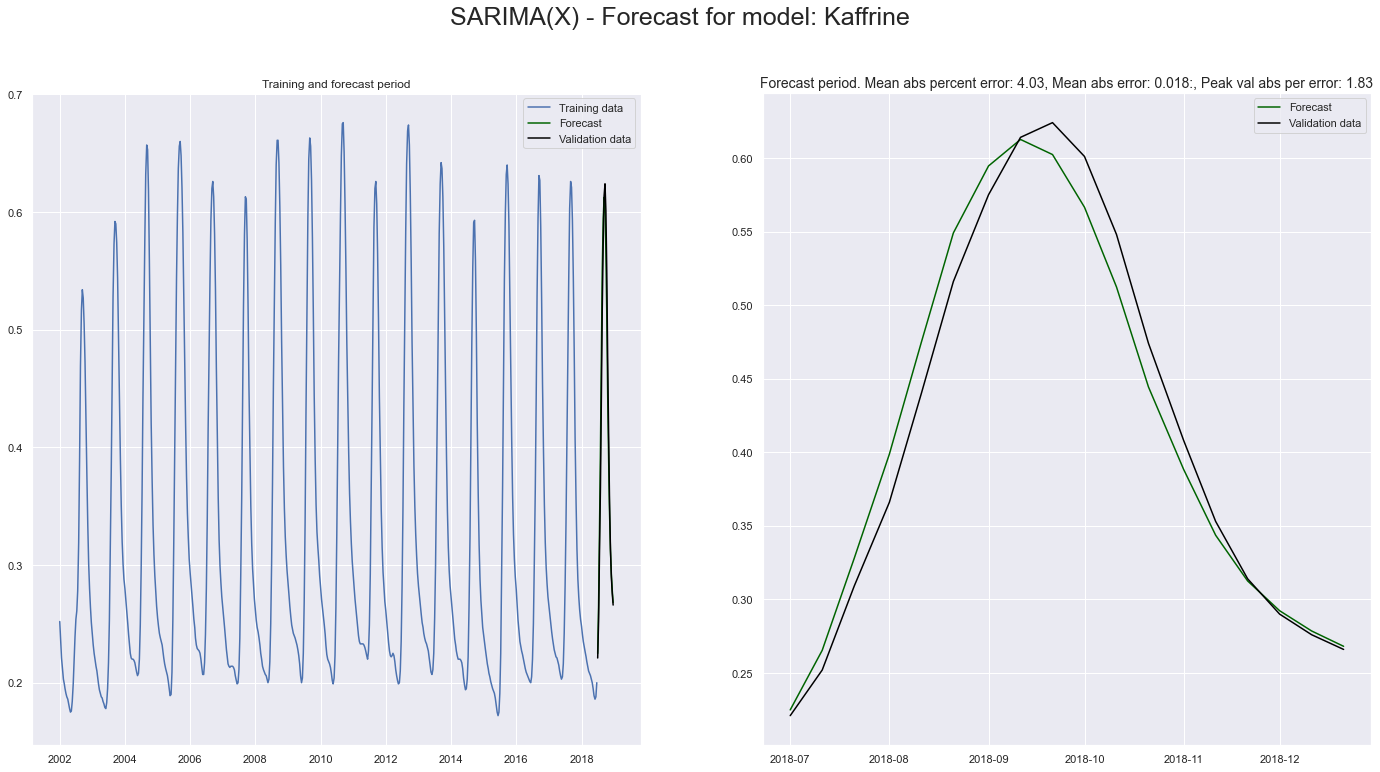

Kaolack
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop     Kaolack          NDVI  0.273
2018-07-11       Crop     Kaolack          NDVI  0.321
2018-07-21       Crop     Kaolack          NDVI  0.388
2018-08-01       Crop     Kaolack          NDVI  0.454
2018-08-11       Crop     Kaolack          NDVI  0.523
2018-08-21       Crop     Kaolack          NDVI  0.589
2018-09-01       Crop     Kaolack          NDVI  0.629
2018-09-11       Crop     Kaolack          NDVI  0.643
2018-09-21       Crop     Kaolack          NDVI  0.635
2018-10-01       Crop     Kaolack          NDVI  0.603
2018-10-11       Crop     Kaolack          NDVI  0.549
2018-10-21       Crop     Kaolack          NDVI  0.474
2018-11-01       Crop     Kaolack          NDVI  0.409
2018-11-11       Crop     Kaolack          NDVI  0.356
2018-11-21       Crop     Kaolack          NDVI  0.318
2018-12-01       Crop     Kaolack          NDVI  0.293
20

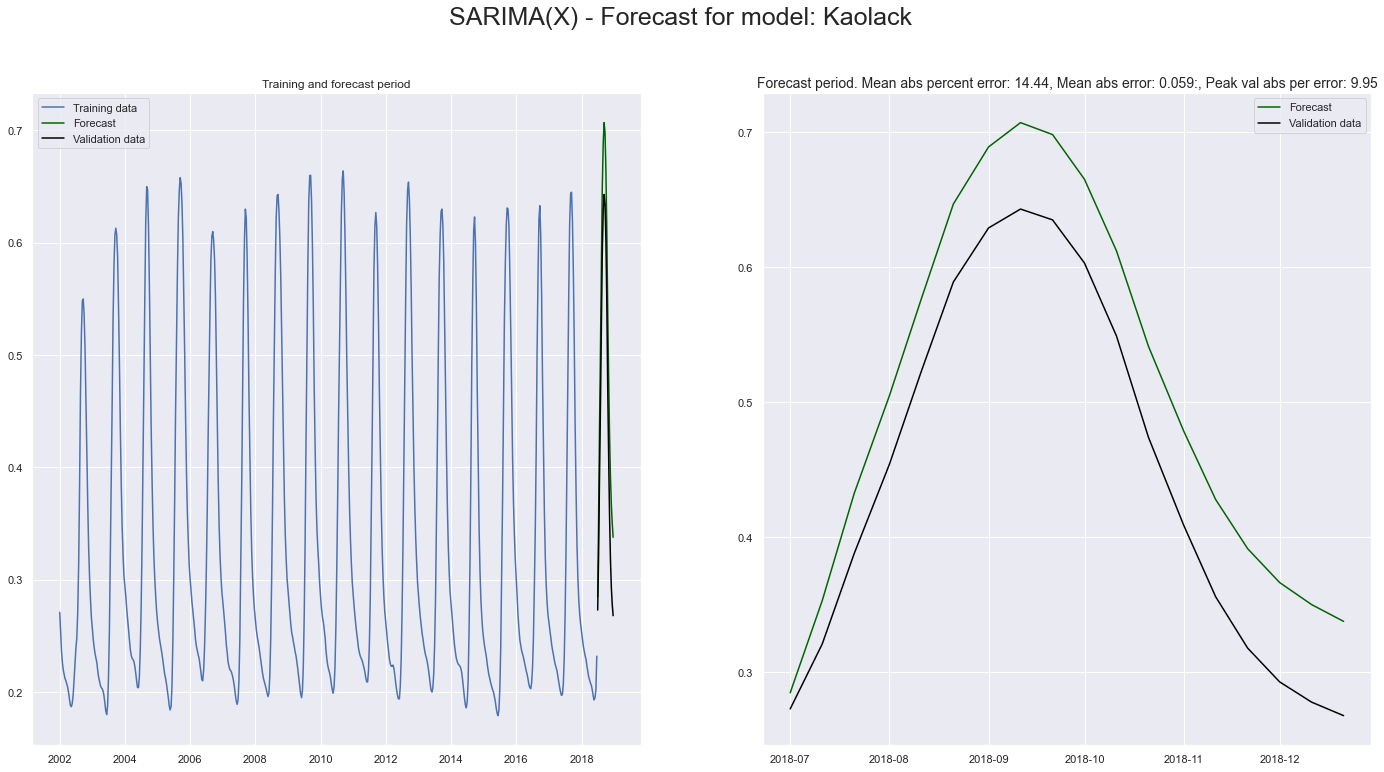

Thies
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop       Thies          NDVI  0.222
2018-07-11       Crop       Thies          NDVI  0.241
2018-07-21       Crop       Thies          NDVI  0.268
2018-08-01       Crop       Thies          NDVI  0.297
2018-08-11       Crop       Thies          NDVI  0.352
2018-08-21       Crop       Thies          NDVI  0.407
2018-09-01       Crop       Thies          NDVI  0.455
2018-09-11       Crop       Thies          NDVI  0.490
2018-09-21       Crop       Thies          NDVI  0.505
2018-10-01       Crop       Thies          NDVI  0.495
2018-10-11       Crop       Thies          NDVI  0.458
2018-10-21       Crop       Thies          NDVI  0.402
2018-11-01       Crop       Thies          NDVI  0.355
2018-11-11       Crop       Thies          NDVI  0.317
2018-11-21       Crop       Thies          NDVI  0.292
2018-12-01       Crop       Thies          NDVI  0.277
2018

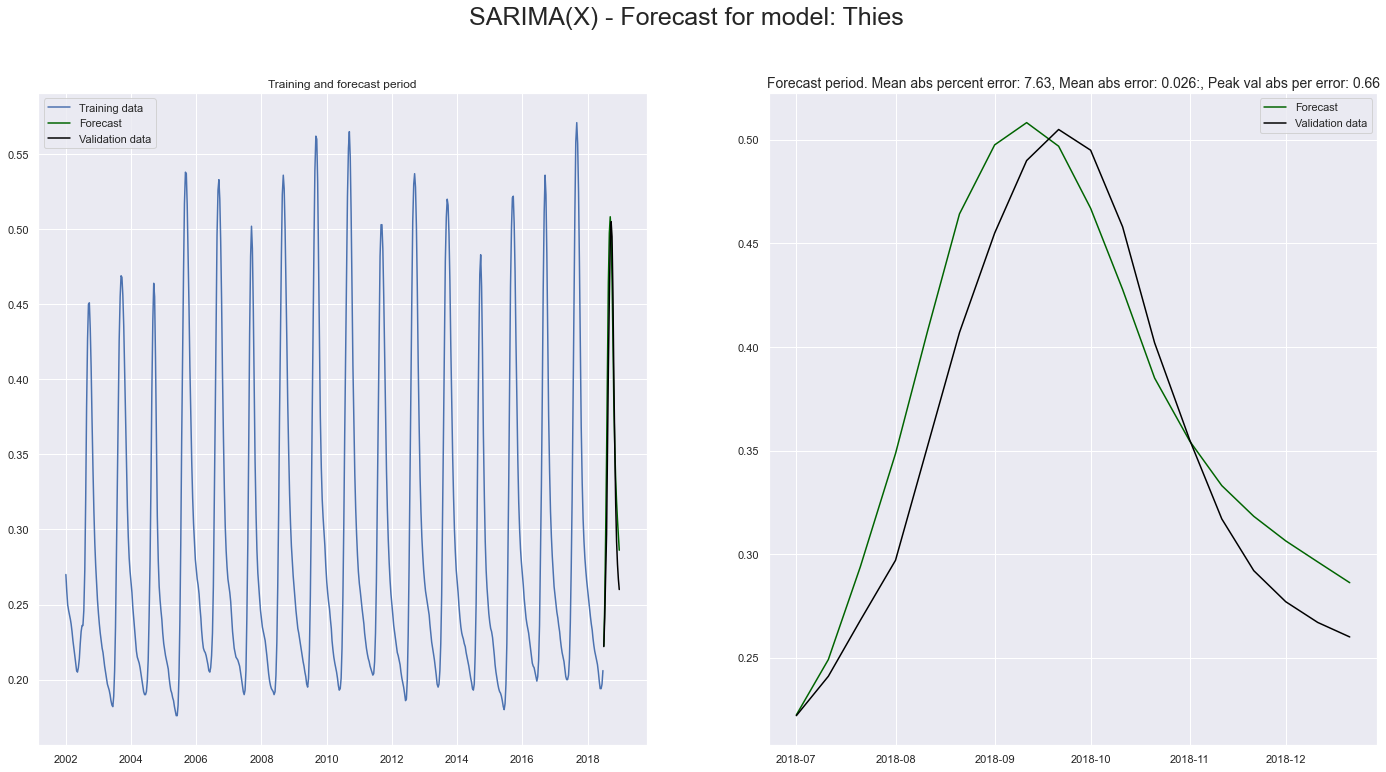

Ziguinchor
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop  Ziguinchor          NDVI  0.499
2018-07-11       Crop  Ziguinchor          NDVI  0.549
2018-07-21       Crop  Ziguinchor          NDVI  0.599
2018-08-01       Crop  Ziguinchor          NDVI  0.638
2018-08-11       Crop  Ziguinchor          NDVI  0.670
2018-08-21       Crop  Ziguinchor          NDVI  0.691
2018-09-01       Crop  Ziguinchor          NDVI  0.700
2018-09-11       Crop  Ziguinchor          NDVI  0.703
2018-09-21       Crop  Ziguinchor          NDVI  0.704
2018-10-01       Crop  Ziguinchor          NDVI  0.705
2018-10-11       Crop  Ziguinchor          NDVI  0.703
2018-10-21       Crop  Ziguinchor          NDVI  0.696
2018-11-01       Crop  Ziguinchor          NDVI  0.681
2018-11-11       Crop  Ziguinchor          NDVI  0.658
2018-11-21       Crop  Ziguinchor          NDVI  0.626
2018-12-01       Crop  Ziguinchor          NDVI  0.592

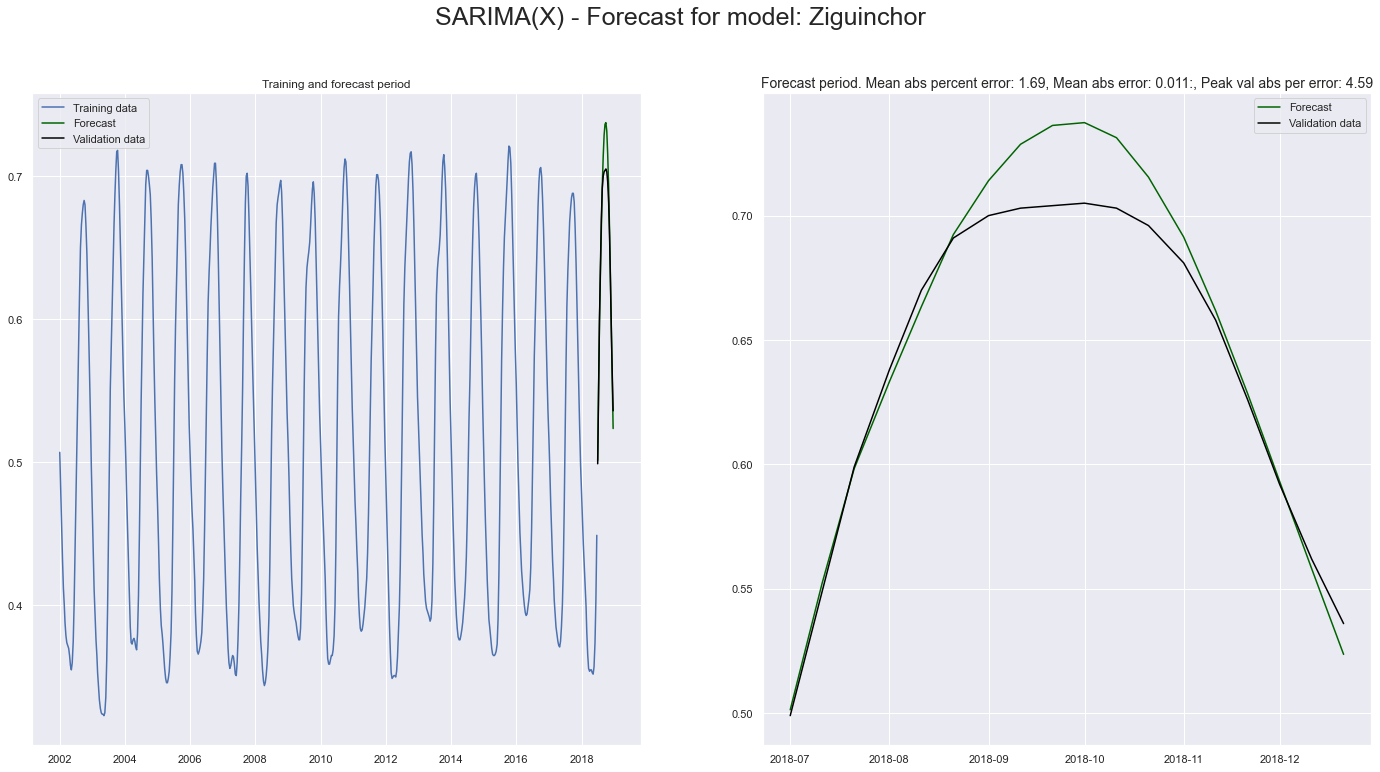

Diourbel
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop    Diourbel          NDVI  0.222
2018-07-11       Crop    Diourbel          NDVI  0.244
2018-07-21       Crop    Diourbel          NDVI  0.285
2018-08-01       Crop    Diourbel          NDVI  0.324
2018-08-11       Crop    Diourbel          NDVI  0.382
2018-08-21       Crop    Diourbel          NDVI  0.441
2018-09-01       Crop    Diourbel          NDVI  0.492
2018-09-11       Crop    Diourbel          NDVI  0.532
2018-09-21       Crop    Diourbel          NDVI  0.556
2018-10-01       Crop    Diourbel          NDVI  0.553
2018-10-11       Crop    Diourbel          NDVI  0.521
2018-10-21       Crop    Diourbel          NDVI  0.462
2018-11-01       Crop    Diourbel          NDVI  0.405
2018-11-11       Crop    Diourbel          NDVI  0.356
2018-11-21       Crop    Diourbel          NDVI  0.319
2018-12-01       Crop    Diourbel          NDVI  0.294
2

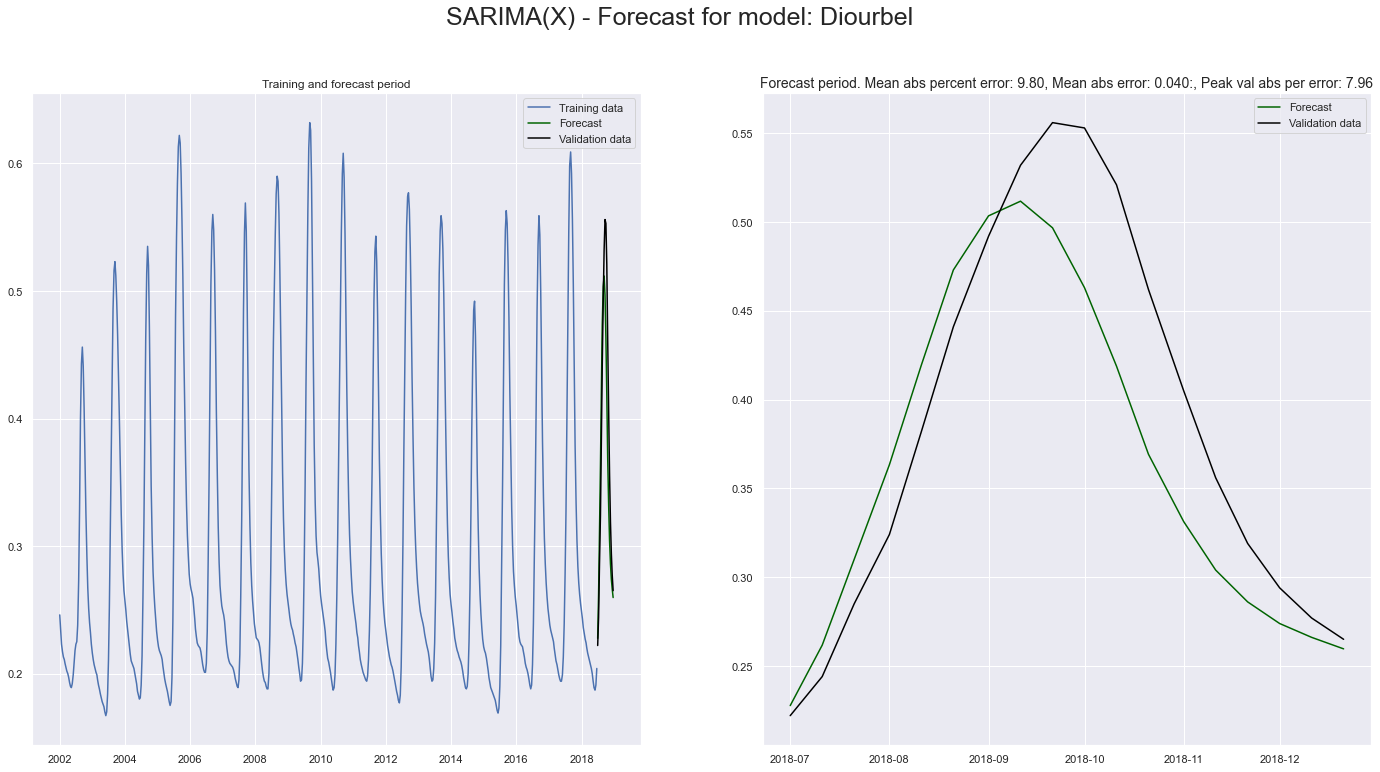

Saint louis
           class_name  region_name variable_name  value
date                                                   
2018-07-01       Crop  Saint louis          NDVI  0.285
2018-07-11       Crop  Saint louis          NDVI  0.284
2018-07-21       Crop  Saint louis          NDVI  0.286
2018-08-01       Crop  Saint louis          NDVI  0.292
2018-08-11       Crop  Saint louis          NDVI  0.310
2018-08-21       Crop  Saint louis          NDVI  0.340
2018-09-01       Crop  Saint louis          NDVI  0.370
2018-09-11       Crop  Saint louis          NDVI  0.393
2018-09-21       Crop  Saint louis          NDVI  0.401
2018-10-01       Crop  Saint louis          NDVI  0.393
2018-10-11       Crop  Saint louis          NDVI  0.377
2018-10-21       Crop  Saint louis          NDVI  0.358
2018-11-01       Crop  Saint louis          NDVI  0.343
2018-11-11       Crop  Saint louis          NDVI  0.329
2018-11-21       Crop  Saint louis          NDVI  0.312
2018-12-01       Crop  Saint louis  

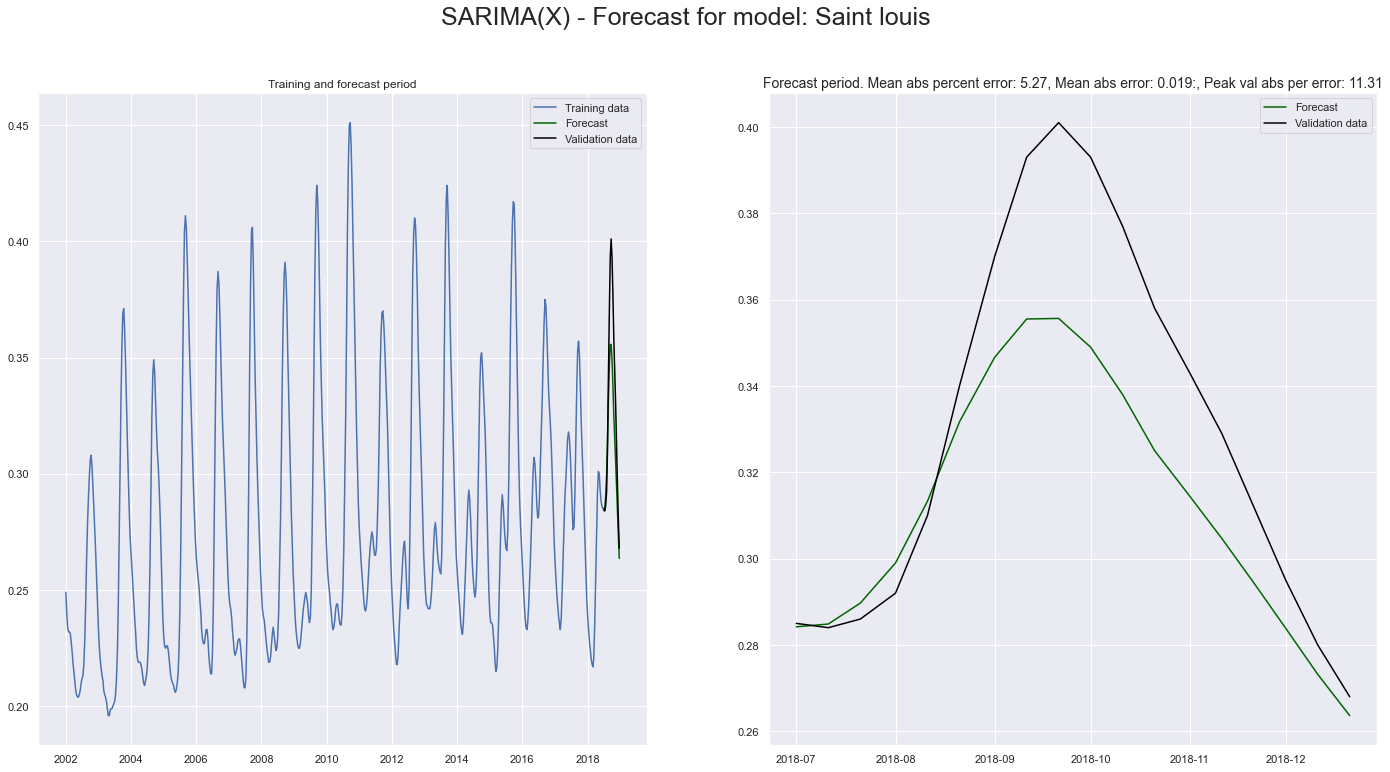

Louga
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop       Louga          NDVI  0.202
2018-07-11       Crop       Louga          NDVI  0.218
2018-07-21       Crop       Louga          NDVI  0.242
2018-08-01       Crop       Louga          NDVI  0.270
2018-08-11       Crop       Louga          NDVI  0.317
2018-08-21       Crop       Louga          NDVI  0.374
2018-09-01       Crop       Louga          NDVI  0.426
2018-09-11       Crop       Louga          NDVI  0.466
2018-09-21       Crop       Louga          NDVI  0.482
2018-10-01       Crop       Louga          NDVI  0.467
2018-10-11       Crop       Louga          NDVI  0.427
2018-10-21       Crop       Louga          NDVI  0.368
2018-11-01       Crop       Louga          NDVI  0.320
2018-11-11       Crop       Louga          NDVI  0.284
2018-11-21       Crop       Louga          NDVI  0.261
2018-12-01       Crop       Louga          NDVI  0.248
2018

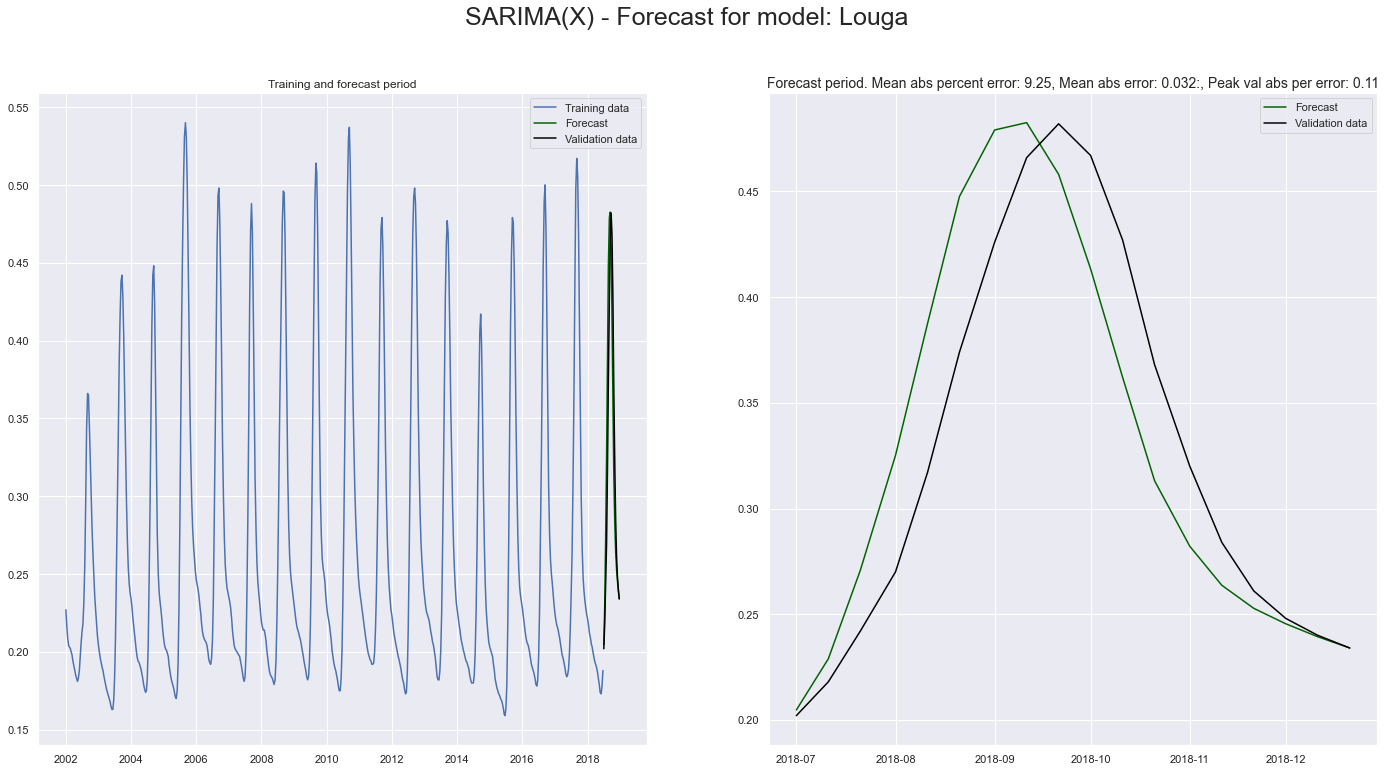

Matam
           class_name region_name variable_name  value
date                                                  
2018-07-01       Crop       Matam          NDVI  0.241
2018-07-11       Crop       Matam          NDVI  0.282
2018-07-21       Crop       Matam          NDVI  0.333
2018-08-01       Crop       Matam          NDVI  0.377
2018-08-11       Crop       Matam          NDVI  0.423
2018-08-21       Crop       Matam          NDVI  0.471
2018-09-01       Crop       Matam          NDVI  0.504
2018-09-11       Crop       Matam          NDVI  0.518
2018-09-21       Crop       Matam          NDVI  0.505
2018-10-01       Crop       Matam          NDVI  0.471
2018-10-11       Crop       Matam          NDVI  0.427
2018-10-21       Crop       Matam          NDVI  0.376
2018-11-01       Crop       Matam          NDVI  0.335
2018-11-11       Crop       Matam          NDVI  0.303
2018-11-21       Crop       Matam          NDVI  0.279
2018-12-01       Crop       Matam          NDVI  0.261
2018

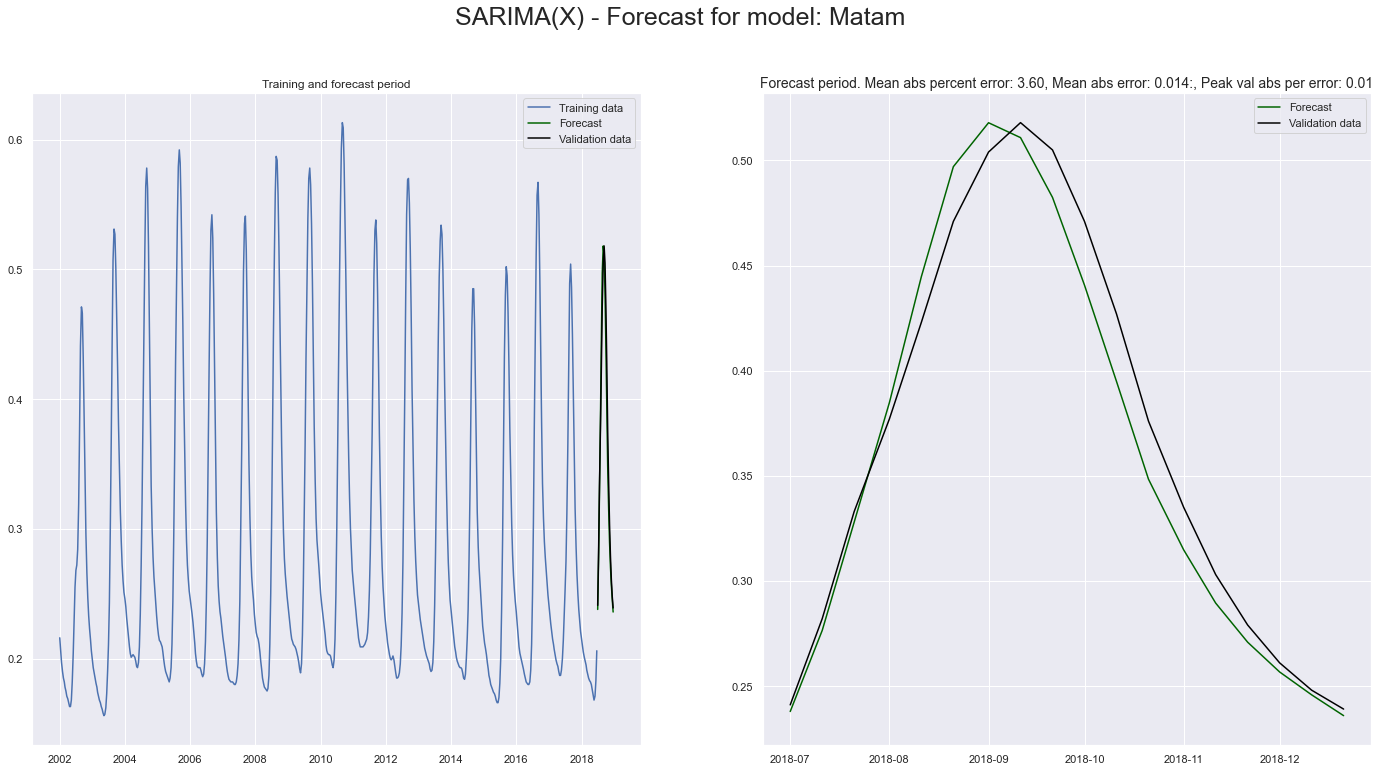

In [25]:
for r in region_list:
    print(r)
    training_df = region_ndvi_training_dict[r]
    val_df = region_ndvi_val_dict[r]
    print(val_df)
    with open('timeseries_models/sarima_forecast_model_'+r+'.pkl', 'rb') as pkl:
        model = pickle.load(pkl)
    pred = get_predictions_sarima(model, val_df)
    plot_training_validation_forecast(training_df, pred, val_df.value, which_model=r)

Some of the models could not predict the NDVI well and could benefit from optimization or additional variables. 